# Resources and credit:
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html
- Conceptual: https://medium.com/@hirotoschwert/digging-into-detectron-2-part-5-6e220d762f9

# Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 8.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=501c1cc4e8a0f7cff46933916ad8158aed600599f7f9afb418fc3f3ed965c628
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 6.8MB/s 
     |████████████████████████████████| 2.2MB 8.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20210127-cp36-none-any.whl size=41425 sha256=bec11e7dcd64f47bc8e4786d8afbc6883b4f3de30beff2242de91cd1de05abb5
  Stored in directory: /root/.cache/pip/wheels/7b/63/ad/ecd606dc6a5de95ab08b07f1bebdaa47f706a541ef4fc4f6ae
  Created wheel for iopath: filename=iopath-0.1.3-cp36-none-any.whl size=11169 sha256=f2414e798eaa1546cb9578a42c612e37f2eeacb43b5f1e53ea8bfacc179cbf87
  Stored in directory: /root/.cache/pip/wheels/a9/1d/55/94a55e032409ac7617f9cbb88a0fa2cf4e7208806c29730804
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0

# Registration
*Register train, test, test_offshore, test_inshore datasets*

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [3]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from detectron2.structures import BoxMode
# Register
for d in ["train", "test", "test_offshore", "test_inshore"]:
    DatasetCatalog.register(d, lambda d=d: get_dict(d))
    MetadataCatalog.get(d).set(thing_classes=["ship"])

AssertionError: ignored

In [5]:
# Instances of metadata
train_metadata = MetadataCatalog.get('train')
test_metadata = MetadataCatalog.get('test')
test_offshore = MetadataCatalog.get('test_offshore')
train_offshore = MetadataCatalog.get('train_offshore')

# Model Loading

In [6]:
# Quick copy/paste of models
# "./ModelOutput/faster_rcnn_R_50_FPN_3x_1_23_2021_36000iters"
#"COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [7]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_50_FPN_3x_1_23_2021_36000iters" # Replace w/ folder

/content/drive/MyDrive/SSDD


In [8]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # Replace w/ config
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ship)
cfg.OUTPUT_DIR = model_name
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Load custom weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # pg.23 of Zhang et al.
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST  = 0.5 # pg.23 of Zhang et al.
#cfg.MODEL.DEVICE = 'cpu'

## Initialize Trainer
*Hidden for brevity*

In [9]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

[01/27 05:08:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Visualization

In [ ]:
predictor = DefaultPredictor(cfg)

In [ ]:
dataset_dicts = get_dict("test")
# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

In [ ]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  from detectron2.utils.visualizer import Visualizer
  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  if predFlag:
    outputs = predictor(im)  
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  image = out.get_image()[:, :, ::-1]
  return image

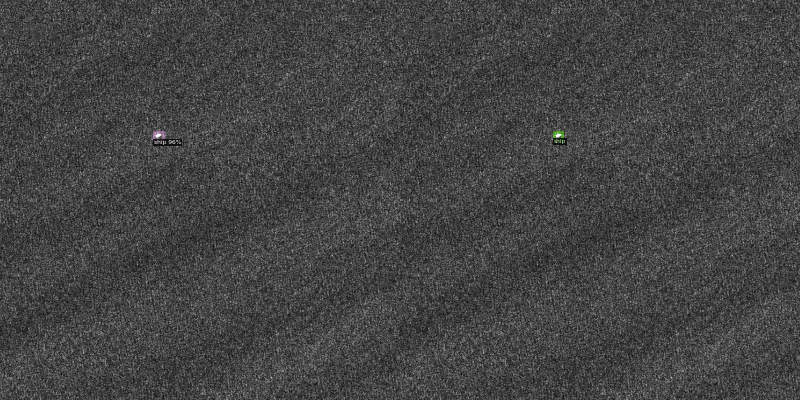

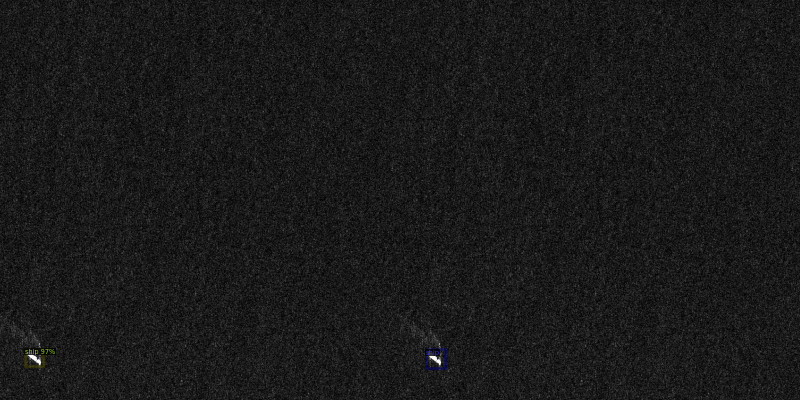

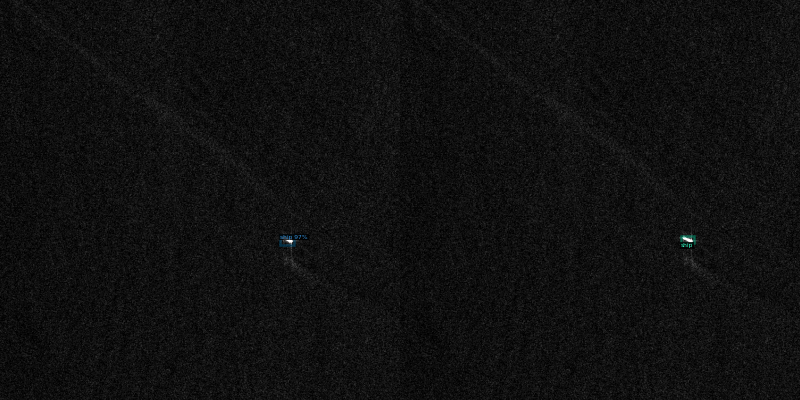

In [ ]:
from cv2 import hconcat
num_samples = 3
os.makedirs(model_name + "/predImages", exist_ok=True) # Make a directory for output images

set.seed(1)
for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True) # Predictions
  image2 = printImage(d, test_metadata, False) # Ground truth
  image3 = hconcat([image1, image2])
  cv2_imshow(image3)
  cv2.imwrite(model_name + '/predImages/' + str(d["image_id"] + '.jpg'), image3)

# Evaluation

## Background

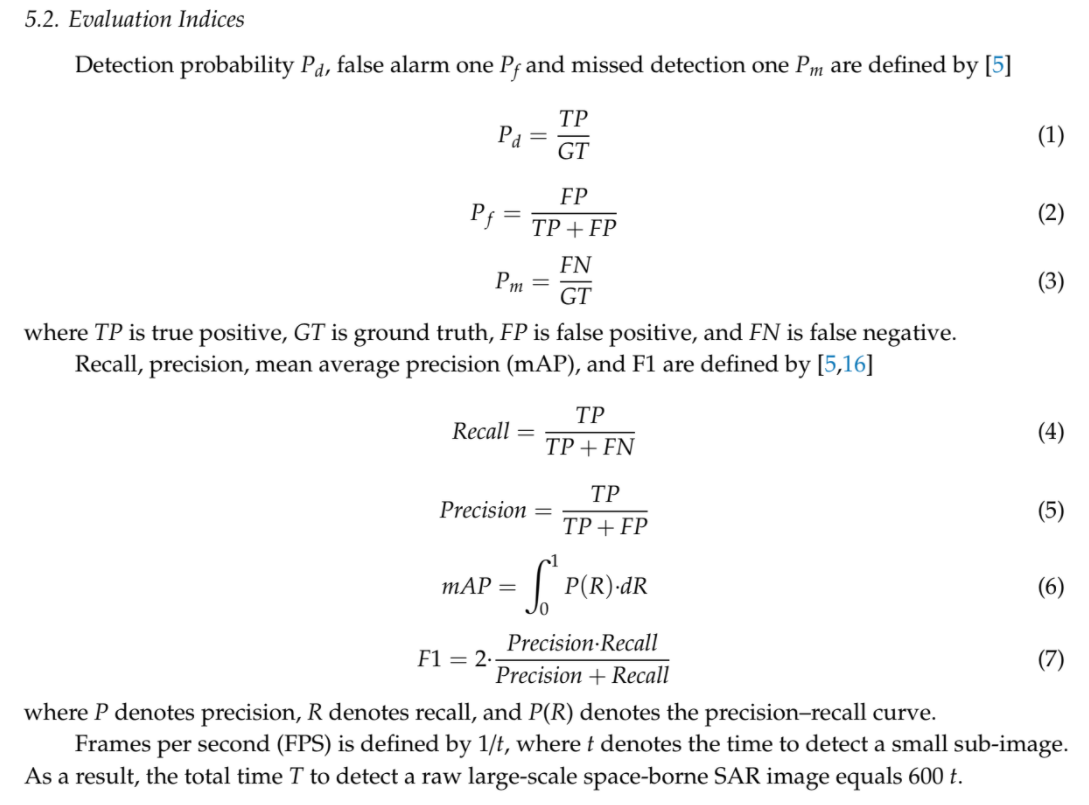

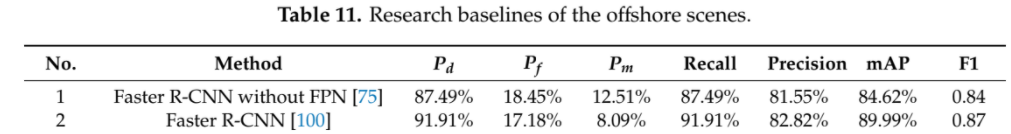

## Prediction

### Custom Evaluator

In [86]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from collections import OrderedDict
from pycocotools.coco import COCO
import contextlib
import torch
import copy
import os
import io

class CustomEvaluator(DatasetEvaluator):
  def __init__(
        self,
        dataset_name,
        output_dir
    ):
    self._cpu_device = torch.device("cpu")
    self._metadata = MetadataCatalog.get(dataset_name)
    self._output_dir = output_dir
    if not hasattr(self._metadata, "json_file"):
      cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
      self._metadata.json_file = cache_path
      convert_to_coco_json(dataset_name, cache_path)

    json_file = PathManager.get_local_path(self._metadata.json_file)
    with contextlib.redirect_stdout(io.StringIO()):
        self._coco_api = COCO(json_file)
    
  def reset(self):
    """
    Preparation for a new round of evaluation.
    """
    self._predictions = []

  def process(self, inputs, outputs):
    """
    Process the pair of inputs and outputs.
    """
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device) 
      if len(prediction) > 1:
          self._predictions.append(prediction)
    if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(self._predictions, f)

  def evaluate(self):
    """
    Evaluate/summarize the performance, after processing all input/output pairs.
    """
    gt_overlaps = []
    num_instances = 0

    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)

      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno =  self._coco_api.loadAnns(ann_ids)
      gt_boxes = [
          BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
          for obj in anno
          if obj["iscrowd"] == 0
      ]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

      if len(gt_boxes) == 0 or len(predictions) == 0:
          continue

      overlaps = pairwise_iou(predictions.get_fields()['pred_boxes'], gt_boxes)

      _gt_overlaps = torch.zeros(len(gt_boxes))
      for j in range(min(len(predictions), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)
          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0
          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]
          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]
          assert _gt_overlaps[j] == gt_ovr
          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1
      
      # append recorded iou coverage level
      gt_overlaps.append(_gt_overlaps)

    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps)
         else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    # True Positive
    TP = (gt_overlaps >= 0.5).int().sum().item()
    # False Positive
    FP = num_instances - TP
    # Ground Truth
    GT = len(self._coco_api.getAnnIds())
    # False Negatives
    FN = GT - TP
    # Detection Probability Pd = TP / GT
    Pd = TP / GT
    # False Alarm Probability Pf = FP / TP + FP
    Pf = FP / (TP + FP)
    # Probability of Missed Detection Pm = FN / GT
    Pm = FN / GT

    # Only precision/recall calculated over IOUs
    step = 0.05
    thresholds = torch.arange(0.50, 0.95 + 1e-5, step,
                              dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    precisions = torch.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        temp = (gt_overlaps >= t).float().sum()
        recalls[i] = temp / float(GT)
        precisions[i] = temp / float(num_instances)

    recall = recalls[0].item()
    precision = precisions[0].item()

    # F1
    F1 = 2*(precision * recall)/(precision + recall)

    self._results = {
        "TP": TP,
        "FP": FP,
        "GT": GT,
        "FN": FN,
        "Pd": Pd,
        "Pf": Pf,
        "Pm": Pm,
        "recalls": recalls,
        "precisions": precisions,
        "recall": recall,
        "precision": precision,
        #"mAP": mAP,
        "F1": F1,
        "gt_overlaps": gt_overlaps,
        "thresholds": thresholds
    }
    return copy.deepcopy(self._results)

### Run Predictions

In [87]:
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.data import build_detection_test_loader
val = './datasets/test/'
evaluator = COCOEvaluator('test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
custEval = CustomEvaluator('test', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'test')

[01/27 06:29:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/27 06:29:57 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[01/27 06:29:57 d2.data.common]: Serialized dataset takes 0.53 MiB


In [53]:
inference = inference_on_dataset(trainer.model,
                                 val_loader,
                                 DatasetEvaluators([evaluator,
                                                   custEval]))

[01/27 05:38:07 d2.evaluation.evaluator]: Start inference on 3000 images
[01/27 05:38:09 d2.evaluation.evaluator]: Inference done 11/3000. 0.0828 s / img. ETA=0:04:42
[01/27 05:38:15 d2.evaluation.evaluator]: Inference done 64/3000. 0.0800 s / img. ETA=0:05:53
[01/27 05:38:20 d2.evaluation.evaluator]: Inference done 114/3000. 0.0802 s / img. ETA=0:05:22
[01/27 05:38:25 d2.evaluation.evaluator]: Inference done 163/3000. 0.0799 s / img. ETA=0:05:10
[01/27 05:38:30 d2.evaluation.evaluator]: Inference done 211/3000. 0.0797 s / img. ETA=0:05:02
[01/27 05:38:36 d2.evaluation.evaluator]: Inference done 257/3000. 0.0797 s / img. ETA=0:04:59
[01/27 05:38:41 d2.evaluation.evaluator]: Inference done 299/3000. 0.0795 s / img. ETA=0:04:59
[01/27 05:38:46 d2.evaluation.evaluator]: Inference done 341/3000. 0.0793 s / img. ETA=0:04:57
[01/27 05:38:51 d2.evaluation.evaluator]: Inference done 381/3000. 0.0791 s / img. ETA=0:04:57
[01/27 05:38:56 d2.evaluation.evaluator]: Inference done 421/3000. 0.0789 

In [88]:
custEval._predictions = temp
eval = custEval.evaluate()
eval

{'F1': 0.6765432019479198,
 'FN': 1008,
 'FP': 302,
 'GT': 2378,
 'Pd': 0.5761143818334735,
 'Pf': 0.180622009569378,
 'Pm': 0.4238856181665265,
 'TP': 1370,
 'gt_overlaps': tensor([0.0000, 0.0000, 0.0000,  ..., 0.9474, 0.9503, 0.9522]),
 'precision': 0.8193780183792114,
 'precisions': tensor([0.8194, 0.7823, 0.7135, 0.5897, 0.4516, 0.3158, 0.1639, 0.0628, 0.0132,
         0.0012]),
 'recall': 0.5761143565177917,
 'recalls': tensor([0.5761, 0.5500, 0.5017, 0.4146, 0.3175, 0.2220, 0.1152, 0.0442, 0.0093,
         0.0008]),
 'thresholds': tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
         0.9500])}

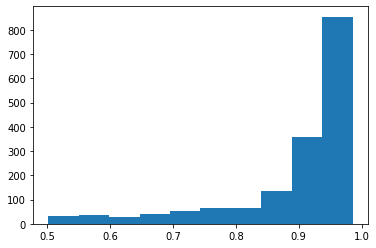

In [114]:
preds = custEval._predictions
scores = [i['instances'].get_fields()['scores'].tolist() for i in preds]
scores = list(itertools.chain.from_iterable(scores))
plt.hist(scores)
plt.show()

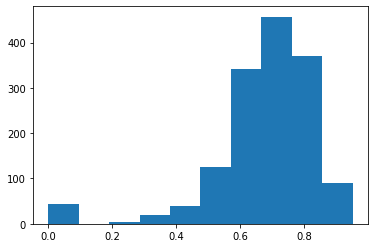

In [116]:
plt.hist(eval['gt_overlaps'])
plt.show()